In [1]:
import numpy as np
from matplotlib import pyplot as plt
import imageio
import cv2 
import os


from funciones.Saliency import *
from funciones.abs import *
from funciones.wet_in_wet import *
from funciones.colorAdj import *




In [25]:
%%writefile funciones/abs2.py

import cv2
import numpy as np
from matplotlib import pyplot as plt

def clamp(n,a,b):
    if (n<a):
        out = a
    elif (n>b):
        out = b
    else:
        out = n
        
    if out % 2 == 0:#impar
        out+=1
        
    return out

def abstraction_v2(src,saliency,d,graph=True,hs=10,hr=20):
    #hs=10#8
    #hr=20#5.5
    M=3#50

    dst=cv2.pyrMeanShiftFiltering(src, hs,hr)#,M)
    
    if graph:
        
        src_RGB=cv2.cvtColor(src,cv2.COLOR_LAB2RGB)
        dst_RGB=cv2.cvtColor(dst,cv2.COLOR_LAB2RGB)

        plt.figure(figsize=(40,20))
        plt.subplot(1,2,1)
        plt.title('Entrada')
        plt.imshow(src_RGB)
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.title('Salida Mean Shift')
        plt.imshow(dst_RGB)
        plt.axis('off')
        
    tag=np.zeros((dst.shape[0],dst.shape[1]))
    
    #considerar regiones
    lista=[]
    for i in range(dst.shape[0]):
        for j in range(dst.shape[1]):
            lista.append(dst[i,j])    

    lista_colores=np.unique(lista,axis=0)
    color=0
    for colors in lista_colores:
        ch1,ch2,ch3=colors
        mask1= dst[:,:,0] == ch1

        mask2= dst[:,:,1] == ch2

        mask3= dst[:,:,2] == ch3

        mask_region =mask1*mask2*mask3
        #print(mask_region.shape)


        tag[mask_region]=color
        color+=1
        
    if graph:
        
        plt.figure(figsize=(20,40))
        plt.title('Regiones')
        plt.imshow(tag,cmap='Purples')
        plt.axis('off')

    #saliency=SaliencyDetection(src)
    #d=SaliencyDistanceField(src, graph=True)
    #Filter:
    M,N=tag.shape
    J=dst.copy()


    ancho=5
    regiones=np.unique(tag)
    regiones_saliency=np.unique(tag[saliency==1])

    #regiones dentro del saliency:

    for  r in regiones_saliency  :
        mask= tag == r  #un canal
        #si estoy en region saliency:

        blur=J
        blur=cv2.GaussianBlur(blur,(ancho,ancho), 0, 0)

        J[:,:,0] = J[:,:,0] + ( ( blur[:,:,0] - J[:,:,0]) * mask )
        J[:,:,1] = J[:,:,1] + ( ( blur[:,:,1] - J[:,:,1]) * mask )
        J[:,:,2] = J[:,:,2] + ( ( blur[:,:,2] - J[:,:,2]) * mask )


    #regiones fuera del saliency:
    regiones_pasadas=[]

    for i in range(M):
        for j in range(N):

            region=tag[i,j]



            if region not in regiones_pasadas:
                regiones_pasadas.append(region)
                if region not in regiones_saliency: 


                    dd=d[i,j]



                    K=clamp( int (10 * (dd + 0.3) ) , 4, 9)

                    mask=  d < 1.3*dd
                    mask2= saliency == 0 #no soy saliency


                    regiones_extras=np.unique(tag[mask*mask2])
                    for rx in regiones_extras:
                        if rx not in regiones_pasadas:
                            regiones_pasadas.append(rx)

                    blur=J

                    for _ in range(2):
                    
                        blur=cv2.GaussianBlur(blur,(K,K), 0, 0)

                    J[:,:,0] = J[:,:,0] + ( ( blur[:,:,0] - J[:,:,0]) * mask * mask2 )
                    J[:,:,1] = J[:,:,1] + ( ( blur[:,:,1] - J[:,:,1]) * mask * mask2 )
                    J[:,:,2] = J[:,:,2] + ( ( blur[:,:,2] - J[:,:,2]) * mask * mask2 )






    if graph:

        J_RGB = cv2.cvtColor(J, cv2.COLOR_LAB2RGB)

        plt.figure(figsize=(20,20))
        plt.title('Salida Abstracción')
        plt.imshow(J_RGB)
        plt.axis('off')
    
    return J

        
    

        
    


Overwriting funciones/abs2.py


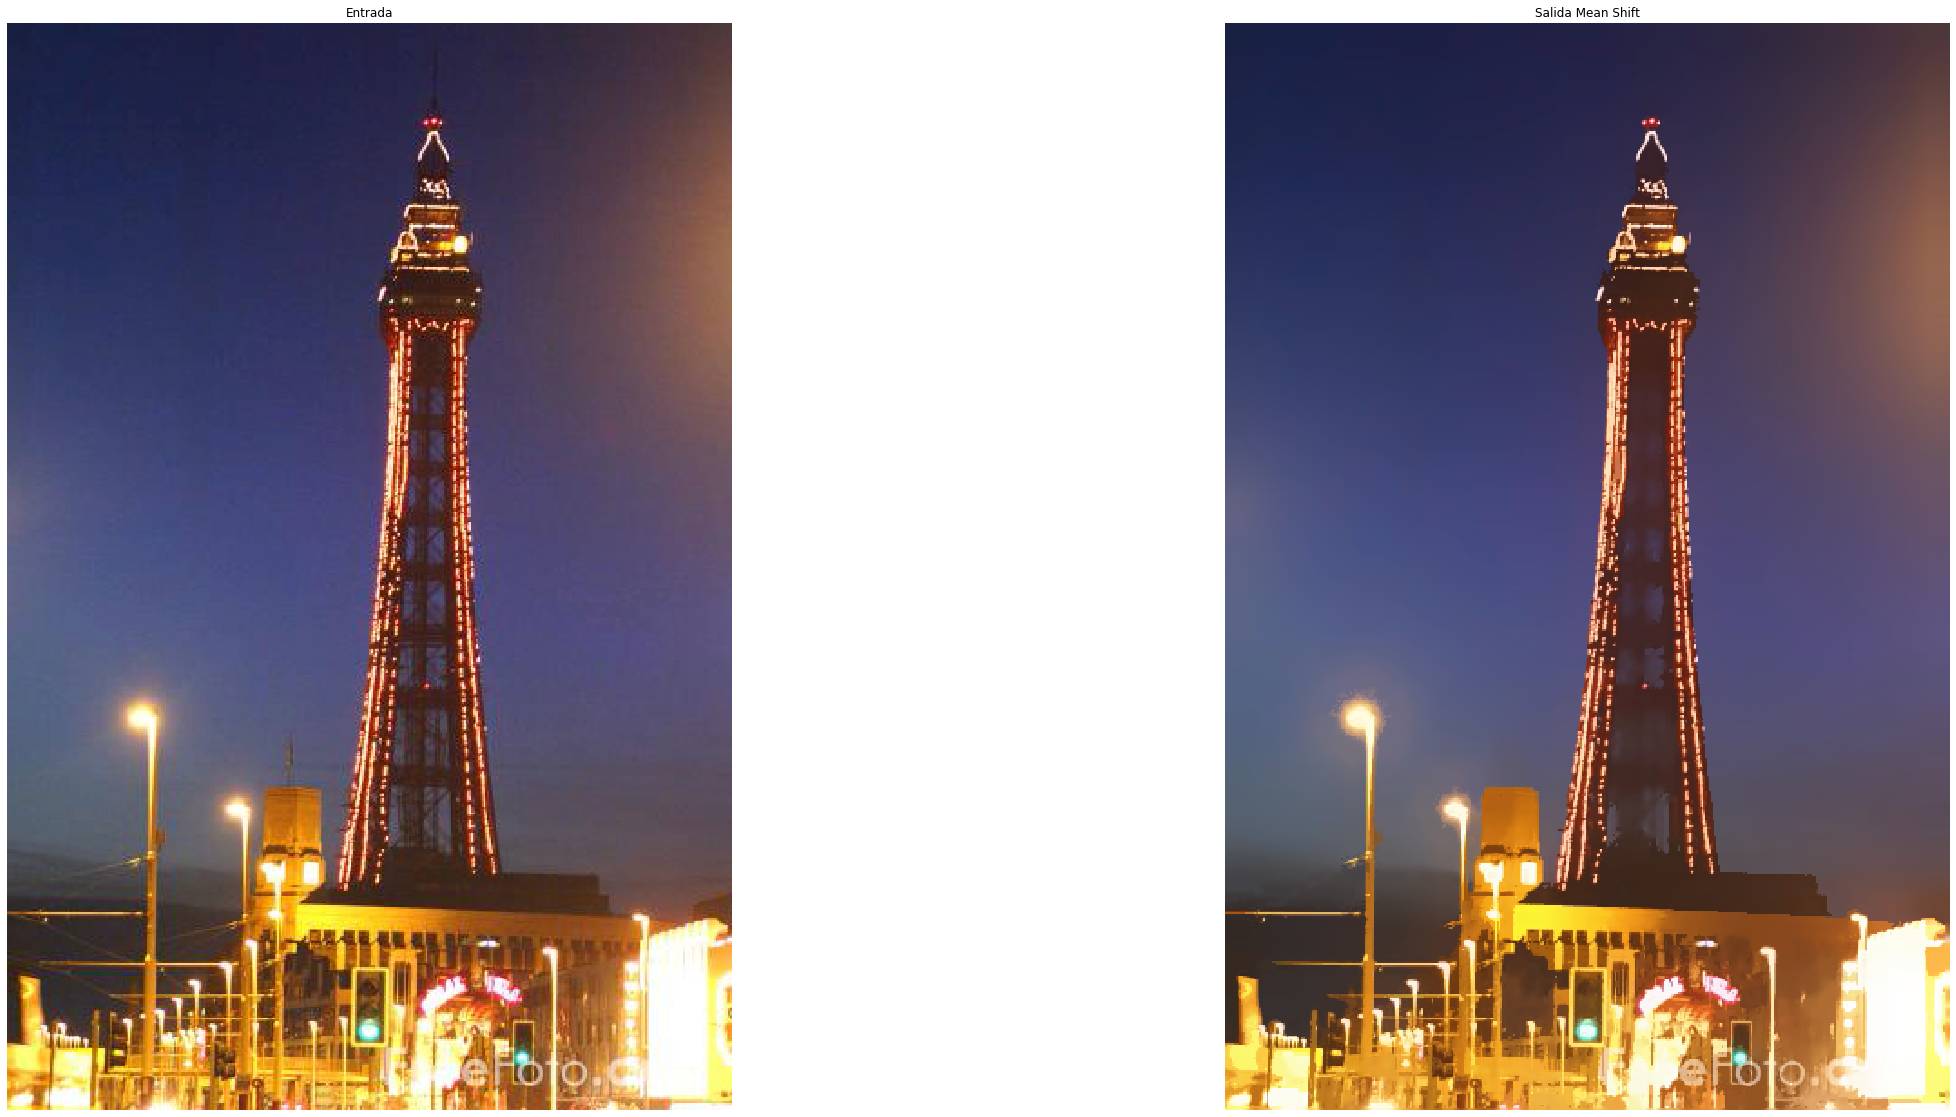

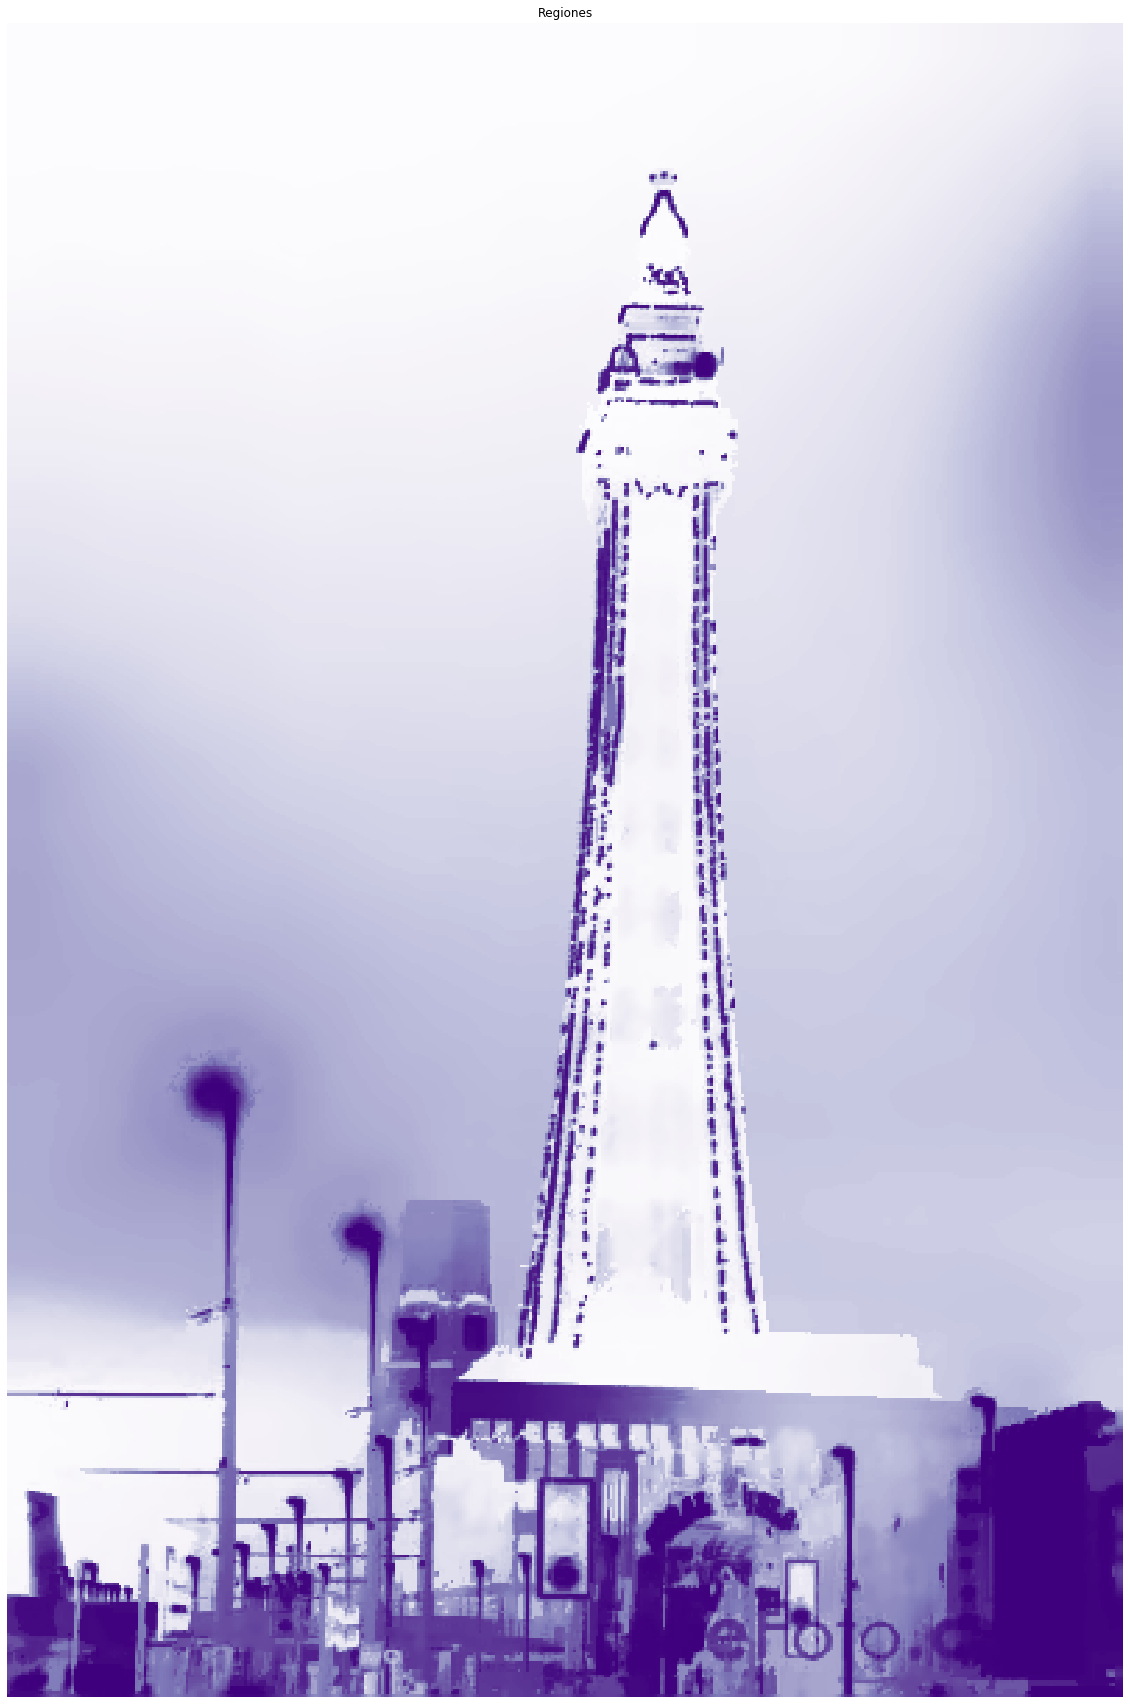

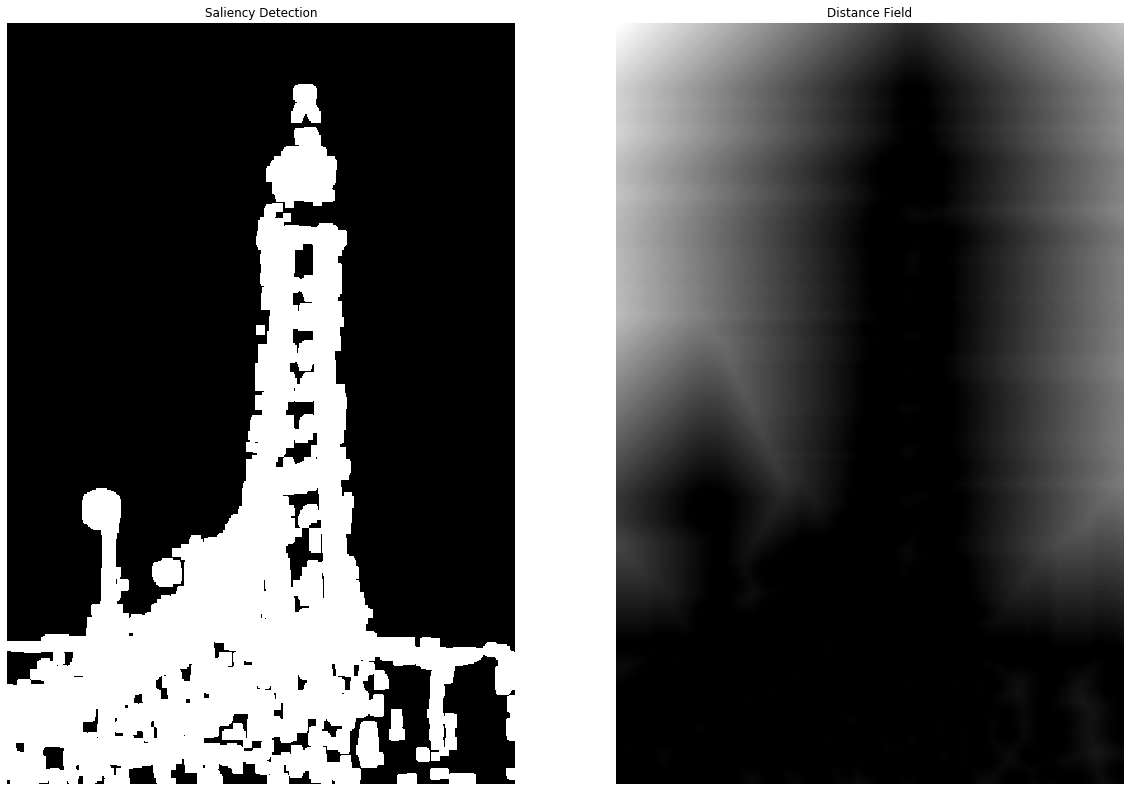

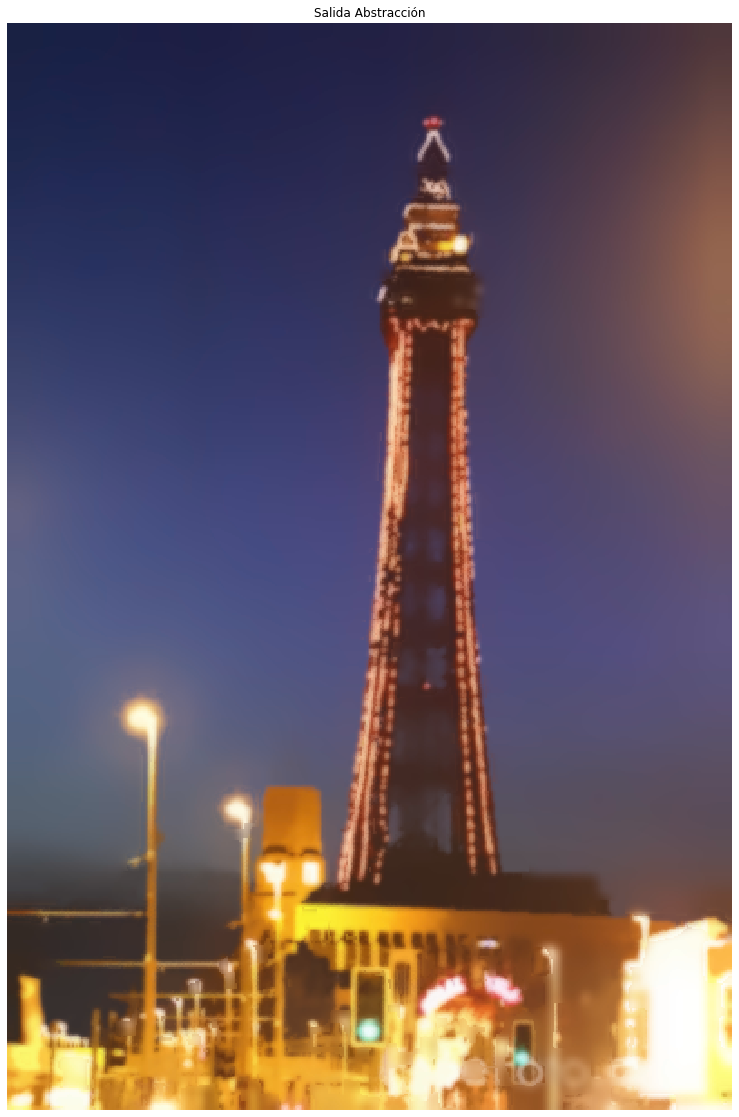

In [21]:
src=cv2.imread('img/torre.png')
#src=cv2.imread('img/tigre.jpg')

src=cv2.cvtColor(src,cv2.COLOR_BGR2LAB)


out_abs=abtraction_v2(src,graph=True)

60906.0


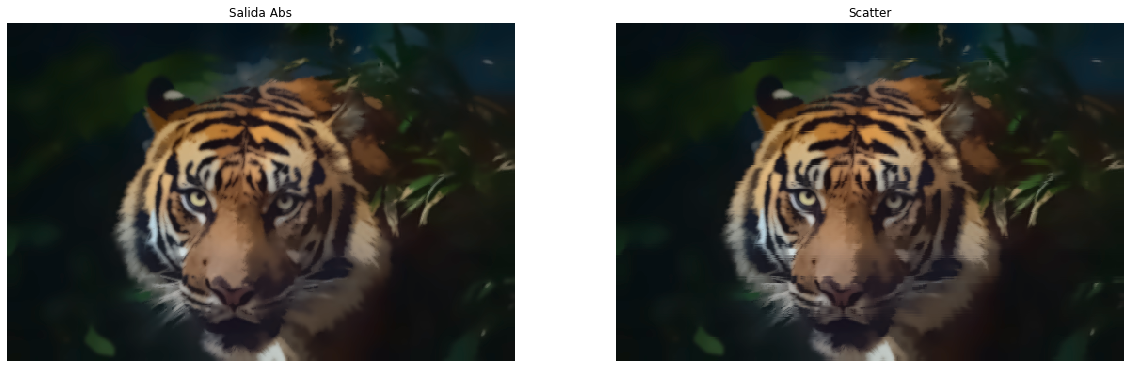

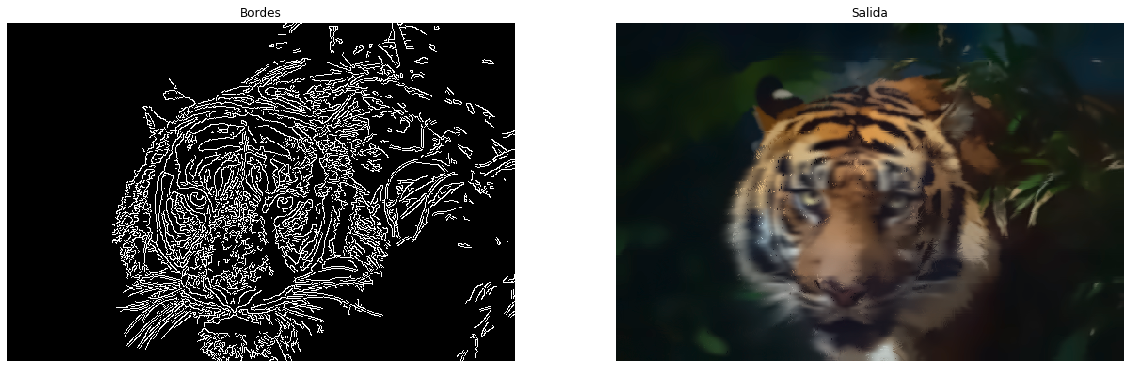

In [53]:
out_wet=wet_in_wet(src,J,d,graph=True, method=1)